In [2]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#USE THIS DOCUMENTATION! IT'S MUCH BETTER:
#https://github.com/COEJKnight/five/blob/0777303f4bee60a10afaccbd0f5c56d880ad0059/usaspending_api/api_docs/api_documentation/advanced_award_search/spending_by_geography.md

In [4]:
url="https://api.usaspending.gov/api/v2/search/spending_by_geography/"
body = []
responses = []

In [5]:
#Don't change this
headers={'Content-Type':'application/json'}

#Removed because data not available before 2007: 2001, 2002, 2003, 2004, 2005, 2006.
years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
#Do change this, depending on the filters that you want to apply (refer to the documentation link above to understand the parameters and output)
for year in years:
    body.append({
            "scope": "place_of_performance",
            "geo_layer": "state",
            #"geo_layer_filters":["MD","VA"],
            "filters": {
                "time_period": [
                    {
                        "start_date": f"{year}-10-01",
                        "end_date": f"{(year+1)}-09-30"
                    }
                    ]}
        })
#body[0] is equivalent to the object returned for year 0 which is 2001

In [6]:
#This is where we make the actual request to the API
for body in body:
    responses.append(requests.post(url, data=json.dumps(body),headers=headers).json())

#responses[0] is equivalent to body[0] which is equivalent to year[0]
#each of the details lines is there because earliest start date for pulls is 2007

responses

[{'scope': 'place_of_performance',
  'geo_layer': 'state',
  'results': [{'shape_code': 'AE',
    'aggregated_amount': 1234907.79,
    'display_name': 'None'},
   {'shape_code': 'AK',
    'aggregated_amount': 4123880794.55,
    'display_name': 'Alaska'},
   {'shape_code': 'AL',
    'aggregated_amount': 23320585479.59,
    'display_name': 'Alabama'},
   {'shape_code': 'AR',
    'aggregated_amount': 9320106146.95,
    'display_name': 'Arkansas'},
   {'shape_code': 'AS',
    'aggregated_amount': 118832800.83,
    'display_name': 'American Samoa'},
   {'shape_code': 'AZ',
    'aggregated_amount': 28687896817.94,
    'display_name': 'Arizona'},
   {'shape_code': 'CA',
    'aggregated_amount': 121806956465.5,
    'display_name': 'California'},
   {'shape_code': 'CO',
    'aggregated_amount': 17049548519.95,
    'display_name': 'Colorado'},
   {'shape_code': 'CT',
    'aggregated_amount': 21540917775.23,
    'display_name': 'Connecticut'},
   {'shape_code': 'DC',
    'aggregated_amount': 1923

In [7]:
# we need to build dataframe, keyed with the years list then enter the responses.json, 
# pull aggregated amount for each relevant state plus shape code(to check) 
# use for loop to get each state's info into DF. 

aggregates =[]
counter = 0

for year in years:
    dataframe = pd.DataFrame(responses[counter]["results"])
    dataframe["year"] = year
    aggregates.append(dataframe)
    counter+=1

aggregates

[   shape_code  aggregated_amount                    display_name  year
 0          AE       1.234908e+06                            None  2007
 1          AK       4.123881e+09                          Alaska  2007
 2          AL       2.332059e+10                         Alabama  2007
 3          AR       9.320106e+09                        Arkansas  2007
 4          AS       1.188328e+08                  American Samoa  2007
 5          AZ       2.868790e+10                         Arizona  2007
 6          CA       1.218070e+11                      California  2007
 7          CO       1.704955e+10                        Colorado  2007
 8          CT       2.154092e+10                     Connecticut  2007
 9          DC       1.923171e+10            District Of Columbia  2007
 10         DE       2.722588e+09                        Delaware  2007
 11         FL       6.547042e+10                         Florida  2007
 12         FM       1.080268e+07  Federated States Of Micronesi

In [8]:
#Pulls aggregates list into single DF

agg_concat = pd.concat(aggregates).reset_index(drop=True)
agg_concat["agg_billions"] = (agg_concat["aggregated_amount"]/1000000000).round(decimals=3)

agg_concat

,shape_code,aggregated_amount,display_name,year,agg_billions
0,AE,1.234908e+06,None,2007,0.001
1,AK,4.123881e+09,Alaska,2007,4.124
2,AL,2.332059e+10,Alabama,2007,23.321
3,AR,9.320106e+09,Arkansas,2007,9.320
4,AS,1.188328e+08,American Samoa,2007,0.119
...,...,...,...,...,...
773,VT,1.683137e+09,Vermont,2019,1.683
774,WA,1.536982e+10,Washington,2019,15.370
775,WI,2.379688e+10,Wisconsin,2019,23.797
776,WV,5.606379e+09,West Virginia,2019,5.606


In [9]:
#focusing on states with longest serving senators.
states = ["CA", "VT", "IA", "AL", "KY", "WA"]
agg_clean = agg_concat[agg_concat["shape_code"].isin(states)]
agg_clean.reset_index(inplace=True, drop=True)

#drops aggregate_amount
agg_clean.drop(columns="aggregated_amount",inplace=True)

agg_clean.head(6)

C:\Users\wargo\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,shape_code,display_name,year,agg_billions
0,AL,Alabama,2007,23.321
1,CA,California,2007,121.807
2,IA,Iowa,2007,9.602
3,KY,Kentucky,2007,18.290
4,VT,Vermont,2007,2.230
5,WA,Washington,2007,25.144


In [10]:
# Establish Senator classes. Source: https://en.wikipedia.org/wiki/Classes_of_United_States_senators
# Note there is redundancy between the classes, because each state has two Senators.
# Establish election years by class.

class_1_str = "Arizona, California, Connecticut, Delaware, Florida, Hawaii, Indiana, Maine, Maryland, Massachusetts, Michigan, Minnesota, Mississippi, Missouri, Montana, Nebraska, Nevada, New Jersey, New Mexico, New York, North Dakota, Ohio, Pennsylvania, Rhode Island, Tennessee, Texas, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming"
class_2_str = "Alabama, Alaska, Arkansas, Colorado, Delaware, Georgia, Idaho, Illinois, Iowa, Kansas, Kentucky, Louisiana, Maine, Massachusetts, Michigan, Minnesota, Mississippi, Montana, Nebraska, New Hampshire, New Jersey, New Mexico, North Carolina, Oklahoma, Oregon, Rhode Island, South Carolina, South Dakota, Tennessee, Texas, Virginia, West Virginia, Wyoming"
class_3_str = "Alabama, Alaska, Arizona, Arkansas, California, Colorado, Connecticut, Florida, Georgia, Hawaii, Idaho, Illinois, Indiana, Iowa, Kansas, Kentucky, Louisiana, Maryland, Missouri, Nevada, New Hampshire, New York, North Carolina, North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, South Carolina, South Dakota, Utah, Vermont, Washington, Wisconsin"

def list_split(string):
    output = list(string.split(", "))
    return output

class_1 = list_split(class_1_str)
class_2 = list_split(class_2_str)
class_3 = list_split(class_3_str)

us_state_abrv = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}
class_1_abrv = [(us_state_abrv[state]) for state in class_1]
class_2_abrv = [(us_state_abrv[state]) for state in class_2]
class_3_abrv = [(us_state_abrv[state]) for state in class_3]

class_1_years = [2018, 2012,2006]
class_2_years = [2020, 2014,2008]
class_3_years = [2016, 2010]

# print(class_1_abrv,class_2_abrv,class_3_abrv)

In [11]:
# Establish aggregate amounts by class. "In YEAR Class 1 had this amount of aggregate spend, in YEAR+1, etc"
agg_concat["class_1"] = agg_concat["shape_code"].isin(class_1_abrv)
agg_concat["class_2"] = agg_concat["shape_code"].isin(class_2_abrv)
agg_concat["class_3"] = agg_concat["shape_code"].isin(class_3_abrv)

agg_concat

,shape_code,aggregated_amount,display_name,year,agg_billions,class_1,class_2,class_3
0,AE,1.234908e+06,None,2007,0.001,False,False,False
1,AK,4.123881e+09,Alaska,2007,4.124,False,True,True
2,AL,2.332059e+10,Alabama,2007,23.321,False,True,True
3,AR,9.320106e+09,Arkansas,2007,9.320,False,True,True
4,AS,1.188328e+08,American Samoa,2007,0.119,False,False,False
...,...,...,...,...,...,...,...,...
773,VT,1.683137e+09,Vermont,2019,1.683,True,False,True
774,WA,1.536982e+10,Washington,2019,15.370,True,False,True
775,WI,2.379688e+10,Wisconsin,2019,23.797,True,False,True
776,WV,5.606379e+09,West Virginia,2019,5.606,True,True,False


In [12]:
# Import and name the CSV file
pop_est = 'nst-est2019-popchg2010_2019.csv'
# The correct encoding must be used to read the CSV in pandas
pop_df = pd.read_csv(pop_est, encoding="ISO-8859-1")
newpop_df = pop_df.rename(columns={"NAME": "display_name", "POPESTIMATE2010": "2010", "POPESTIMATE2011": "2011",
                         "POPESTIMATE2012": "2012", "POPESTIMATE2013": "2013", "POPESTIMATE2014": "2014", 
                          "POPESTIMATE2015": "2015", "POPESTIMATE2016": "2016", "POPESTIMATE2017": "2017", 
                          "POPESTIMATE2017": "2017", "POPESTIMATE2018": "2018", "POPESTIMATE2019": "2019"})
#view dataframe
newpop_df

,SUMLEV,REGION,DIVISION,STATE,display_name,ESTIMATESBASE2010,2010,2011,2012,2013,...,NRANK_PPCHG2010,NRANK_PPCHG2011,NRANK_PPCHG2012,NRANK_PPCHG2013,NRANK_PPCHG2014,NRANK_PPCHG2015,NRANK_PPCHG2016,NRANK_PPCHG2017,NRANK_PPCHG2018,NRANK_PPCHG2019
0,10,0,0,0,United States,308758105,309321666,311556874,313830990,315993715,...,X,X,X,X,X,X,X,X,X,X
1,20,1,0,0,Northeast Region,55318443,55380134,55604223,55775216,55901806,...,3,3,3,4,4,4,4,4,4,4
2,20,2,0,0,Midwest Region,66929725,66974416,67157800,67336743,67560379,...,4,4,4,3,3,3,3,3,3,3
3,20,3,0,0,South Region,114563030,114866680,116006522,117241208,118364400,...,1,1,1,1,1,1,1,1,1,1
4,20,4,0,0,West Region,71946907,72100436,72788329,73477823,74167130,...,2,2,2,2,2,2,2,2,2,2
5,40,3,6,1,Alabama,4780125,4785437,4799069,4815588,4830081,...,37,38,34,33,35,36,34,33,28,26
6,40,4,9,2,Alaska,710249,713910,722128,730443,737068,...,2,7,11,18,48,37,22,48,50,50
7,40,4,8,4,Arizona,6392288,6407172,6472643,6554978,6632764,...,17,10,8,7,7,9,7,6,4,3
8,40,3,7,5,Arkansas,2916031,2921964,2940667,2952164,2959400,...,22,28,31,38,31,30,26,24,27,27
9,40,4,9,6,California,37254519,37319502,37638369,37948800,38260787,...,27,18,20,21,16,17,20,22,29,36


In [13]:
#check datatpye
newpop_df.dtypes["2010"]

dtype('int64')

In [14]:
#Display dataframe; data check
pop_pivot_df = pd.melt(newpop_df, id_vars=["display_name"], value_vars=['2010', '2011', '2012', '2013', '2014', 
                                                                        '2015', '2016', '2017', '2018', '2019'])
print(pop_pivot_df)

         display_name variable      value
0       United States     2010  309321666
1    Northeast Region     2010   55380134
2      Midwest Region     2010   66974416
3        South Region     2010  114866680
4         West Region     2010   72100436
..                ...      ...        ...
565        Washington     2019    7614893
566     West Virginia     2019    1792147
567         Wisconsin     2019    5822434
568           Wyoming     2019     578759
569       Puerto Rico     2019    3193694

[570 rows x 3 columns]


In [15]:
#Change datatype of 'variable' column
pop_mart = pop_pivot_df.astype({'variable':'int64'})
pop_mart.dtypes

display_name    object
variable         int64
value            int64
dtype: object

In [16]:
#Regame 'variable' column to year for merge; change column header 'value' to 'pop' for readability
popremix_df = pop_mart.rename(columns={"variable": "year","value":"pop"})
print(popremix_df)

         display_name  year        pop
0       United States  2010  309321666
1    Northeast Region  2010   55380134
2      Midwest Region  2010   66974416
3        South Region  2010  114866680
4         West Region  2010   72100436
..                ...   ...        ...
565        Washington  2019    7614893
566     West Virginia  2019    1792147
567         Wisconsin  2019    5822434
568           Wyoming  2019     578759
569       Puerto Rico  2019    3193694

[570 rows x 3 columns]


In [17]:
#Merge Datasets
combopop = pd.merge(popremix_df, agg_concat, on= ["display_name", "year"])
combopop.head() 

,display_name,year,pop,shape_code,aggregated_amount,agg_billions,class_1,class_2,class_3
0,Alabama,2010,4785437,AL,4.609843e+10,46.098,False,True,True
1,Alaska,2010,713910,AK,6.516583e+09,6.517,False,True,True
2,Arizona,2010,6407172,AZ,4.960454e+10,49.605,True,False,True
3,Arkansas,2010,2921964,AR,1.761985e+10,17.620,False,True,True
4,California,2010,37319502,CA,2.619174e+11,261.917,True,False,True


In [18]:
#Establish equation for per capita expenditure; create and fill column with data
combopop['per_capita'] = combopop['aggregated_amount']/combopop['pop']
combopop.head()


,display_name,year,pop,shape_code,aggregated_amount,agg_billions,class_1,class_2,class_3,per_capita
0,Alabama,2010,4785437,AL,4.609843e+10,46.098,False,True,True,9633.066338
1,Alaska,2010,713910,AK,6.516583e+09,6.517,False,True,True,9128.016998
2,Arizona,2010,6407172,AZ,4.960454e+10,49.605,True,False,True,7742.033254
3,Arkansas,2010,2921964,AR,1.761985e+10,17.620,False,True,True,6030.140317
4,California,2010,37319502,CA,2.619174e+11,261.917,True,False,True,7018.245500


In [22]:
# visualize dataframe for state by year
cap_year = combopop.groupby(["display_name", "year"]).sum()[["per_capita"]]
cap_year

per_capita
display_name year              
Alabama      2010   9633.066338
             2011   9248.890252
             2012   9085.435585
             2013   7396.253265
             2014  12337.982261
...                         ...
Wyoming      2015   5832.411859
             2016   6814.405788
             2017   7573.710834
             2018   7894.402291
             2019   1785.458645

[510 rows x 1 columns]

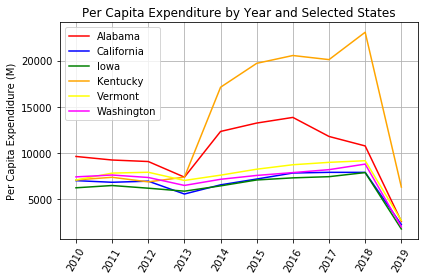

In [42]:
# Make line graph depicting per capita expenditure by state
states = ['Alabama', 'California', 'Iowa', 'Kentucky',  'Vermont', 'Washington']
colors = ['red','blue','green','orange','yellow','magenta']

ind = np.arange(len(list(set(combopop['year']))))
bottoms = []
for state in states:
    stateDF = combopop[combopop['display_name']==state]
    plt.plot(ind,stateDF['per_capita'],color=colors[states.index(state)])

plt.ylabel('Per Capita Expendidure (M)')
plt.title('Per Capita Expenditure by Year and Selected States')
plt.xticks(ind, ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019')) 
plt.xticks(rotation=60)                                                                       
plt.grid()
plt.legend(states)

# Save our graph and show the grap
plt.tight_layout()
plt.savefig("../list_of_dicts/states_percap.png")
plt.show()